In [1]:
import re
import os

from sklearn.preprocessing import StandardScaler        #   type: ignore
import numpy as np                                      #   type: ignore
import pandas as pd                                     #   type: ignore
import matplotlib.pyplot as plt                         #   type: ignore
import seaborn as sns                                   #   type: ignore

### Setup

In [2]:
lothar = '/home/enno/uni/SS24/thesis/1_RegEx/1_TMP'

In [3]:
R = 3
E = '1E-6'
M = 0

In [4]:
if os.getcwd() == lothar:
    df = pd.read_csv('/home/enno/uni/SS24/thesis/1_RegEx/0_data/regEx.csv')
    
    clans_file = f'/home/enno/uni/SS24/thesis/1_RegEx/1_TMP/clans_out/{R}R_{M}MM_seq_{E}.clans'
    clstr_file = f'/home/enno/uni/SS24/thesis/1_RegEx/1_TMP/cd_out/{R}R_{M}MM_seq.clstr'
    
    full_fasta_file = f'/home/enno/uni/SS24/thesis/1_RegEx/0_data/fasta/{R}R_{M}MM_seq.fasta'
    cd_out_fasta_file = f'/home/enno/uni/SS24/thesis/1_RegEx/1_TMP/cd_out/{R}R_{M}MM_seq.fasta'
else:
    df = pd.read_csv('/ebio/abt1_share/prediction_hendecads/1_repo/1_RegEx/0_data/regEx.csv')

    clans_file = f'/ebio/abt1_share/prediction_hendecads/1_repo/1_RegEx/1_TMP/clans_out/{R}R_{M}MM_seq_{E}.clans'
    clstr_file = f'/ebio/abt1_share/prediction_hendecads/1_repo/1_RegEx/1_TMP/cd_out/{R}R_{M}MM_seq.clstr'

    full_fasta_file = f'/ebio/abt1_share/prediction_hendecads/1_repo/1_RegEx/0_data/fasta/{R}R_{M}MM_seq.fasta'
    cd_out_fasta_file = f'/ebio/abt1_share/prediction_hendecads/1_repo/1_RegEx/1_TMP/cd_out/{R}R_{M}MM_seq.fasta'

In [5]:
full_tmp_df = df.loc[df['c'] == 0].reset_index(drop=True)

In [6]:
print(len(df))
df.head()

36455


,id,seq,stretch_ix,stretch_seq,c,npf_x,npf_y,1R_0MM_seq,1R_0MM_ix,1R_0MM_n,...,1R_2MM_n,3R_2MM_seq,3R_2MM_ix,3R_2MM_n,5R_2MM_seq,5R_2MM_ix,5R_2MM_n,10R_2MM_seq,10R_2MM_ix,10R_2MM_n
0,MCD6041253.1,mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...",['rlvyvavaailcsfsttslagaektakragkfvektatragkfv...,-1.0,-567.38850,34.030270,"[['lvyvavaailc', 'vyvavaailcs', 'lagaektakra',...","[[[1, 12], [2, 13], [18, 29], [25, 36], [36, 4...",7,...,37,"[['aailcsfsttslagaektakragkfvektatra', 'sttsla...","[[[7, 40], [14, 47], [18, 51], [25, 58], [36, ...",5,[['sttslagaektakragkfvektatragkfvertatkagkfver...,"[[[14, 69]]]",1,[[]],[[]],0
1,MCD7737945.1,mqgrvffreaaalilaaalsmaglpasaaansgieaaalrteeete...,"[[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, ...",['eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqe...,-1.0,313.18863,-218.576080,[[]],[[]],0,...,58,[[]],[[]],0,[[]],[[]],0,[[]],[[]],0
2,MYF28459.1,merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...",['erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaet...,-1.0,535.79120,-22.468689,"[['ihalrgemhae', 'isgvrervarv', 'varvethlqrt']]","[[[10, 21], [50, 61], [57, 68]]]",3,...,47,"[['ihalrgemhaefasvrqemhagfasirqemhae', 'mhagfa...","[[[10, 43], [28, 61]]]",2,[[]],[[]],0,[[]],[[]],0
3,WP_168920948.1,msdvfltasyadrekvktlgarwnpaekrwyvpsgrdlspfaawlp...,"[[437, 438, 439, 440, 441, 442, 443, 444, 445,...",['aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaq...,41.0,-346.27220,104.598206,"[['aqslvveikha', 'vveikhaasqq', 'lllarhvvpar',...","[[[0, 11], [4, 15], [15, 26], [24, 35], [48, 5...",6,...,82,"[['aqslvveikhaasqqlllarhvvparmaevtae', 'lvveik...","[[[0, 33], [3, 36], [4, 37], [15, 48], [26, 59...",6,[['vveikhaasqqlllarhvvparmaevtaegrqalrtakaqsqa...,"[[[4, 59]]]",1,[[]],[[]],0
4,WP_026306873.1,mllrriarpllsaafiaegidilqnpgpladrlspaldftrrrsqh...,"[[172, 173, 174, 175, 176, 177, 178, 179, 180,...",['slgwrgrraardakdhaealaataaaiaatarergtnlvdtare...,37.0,164.44267,341.078280,"[['ardakdhaeal', 'aealaataaai', 'alaataaaiaa',...","[[[9, 20], [16, 27], [18, 29], [20, 31], [21, ...",15,...,114,"[['lgwrgrraardakdhaealaataaaiaatarer', 'grraar...","[[[1, 34], [5, 38], [9, 42], [12, 45], [16, 49...",15,[[]],[[]],0,[[]],[[]],0


In [7]:
tmp_df = df[(df[f'{R}R_{M}MM_n'] > 0) & (df['c'] == 0)].reset_index(drop=True)
len(tmp_df)

3148

#### .clstr and .clans Parser

In [8]:
def parse_numbers(filename):
    # Extracts the cluster assignment for 5R hits from the .clans file

    clusters = []
    with open(filename, 'r') as file:
       
        for line in file:
            
            if re.match('numbers=', line):
                
                _, num_str = line.split('=')
                numbers = [int(num.strip()) for num in num_str.split(';')[:-1]]

                clusters.append(numbers)
    
    return clusters

In [9]:
clans_numbers = parse_numbers(clans_file)

In [10]:
def parse_cluster_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    clusters = {}
    current_representative = None

    for line in lines:
        if line.startswith('>Cluster'):
            # This line is the start of a new cluster, so the next line will contain the representative sequence
            current_representative = None
        else:
            # This line contains a sequence
            sequence = line.split(', ')[1].split('...')[0].strip()
            if current_representative is None:
                # This is the first sequence in the cluster, so it's the representative sequence
                current_representative = sequence
            clusters[sequence[1:]] = current_representative[1:]

    return clusters

In [11]:
rep_dict = parse_cluster_file(clstr_file)

### Representatives

#### Create DataFrame for Representatives

In [12]:
# NOTE create method?

cd_out_hit_df = pd.DataFrame(columns=['id', 'stretch_x', 'seq_x', 'rep_id'])
ix = 0

with open(cd_out_fasta_file, 'r') as file:

    lines = [line.strip() for line in file.readlines()]
    headers = lines[::2]
    seqs = lines[1::2]
    
    for hx, header_str in enumerate(headers):
        print(f'Progress {hx+1}/{len(headers)}', end='\r')
        
        header = header_str.split('_')
        id, strx, sx = '_'.join(header[:-7])[1:], header[-3], header[-1]
        
        cd_out_hit_df.loc[ix] = [id, strx, sx, header_str[1:]]
        ix += 1

In [13]:
# Assign the cluster number to each sequence
for c, numbers in enumerate(clans_numbers):
    
    cd_out_hit_df.loc[numbers, 'c'] = c

cd_out_hit_df.loc[cd_out_hit_df['c'].isna(), ['c']] = -1  # unassigned = -1
cd_out_hit_df['c'] = cd_out_hit_df['c'].astype(str)

In [14]:
print(len(cd_out_hit_df))
cd_out_hit_df.head()

18044


,id,stretch_x,seq_x,rep_id,c
0,WP_018518335.1,0,0,WP_018518335.1_3R_0MM_seq_stretch_0_seq_0,-1.0
1,WP_018518335.1,0,1,WP_018518335.1_3R_0MM_seq_stretch_0_seq_1,-1.0
2,QZI86829.1,0,0,QZI86829.1_3R_0MM_seq_stretch_0_seq_0,-1.0
3,MBQ9252633.1,0,0,MBQ9252633.1_3R_0MM_seq_stretch_0_seq_0,-1.0
4,MBQ9252633.1,0,1,MBQ9252633.1_3R_0MM_seq_stretch_0_seq_1,-1.0


#### Get Representative Coordinates

In [15]:
# Add x and y coordinates from CLANS to the dataframe
with open(clans_file, 'r') as file:
    data = file.readlines()

data = [line.strip() for line in data]

first_pos = 1
for line in data:
    if line == '<pos>':
        break
    else:
        first_pos += 1

last_pos = first_pos + len(cd_out_hit_df)

pos = [x.split() for x in data[first_pos:last_pos]]

cd_out_hit_df['x'] = [float(x[1]) for x in pos]
cd_out_hit_df['y'] = [float(x[2]) for x in pos]

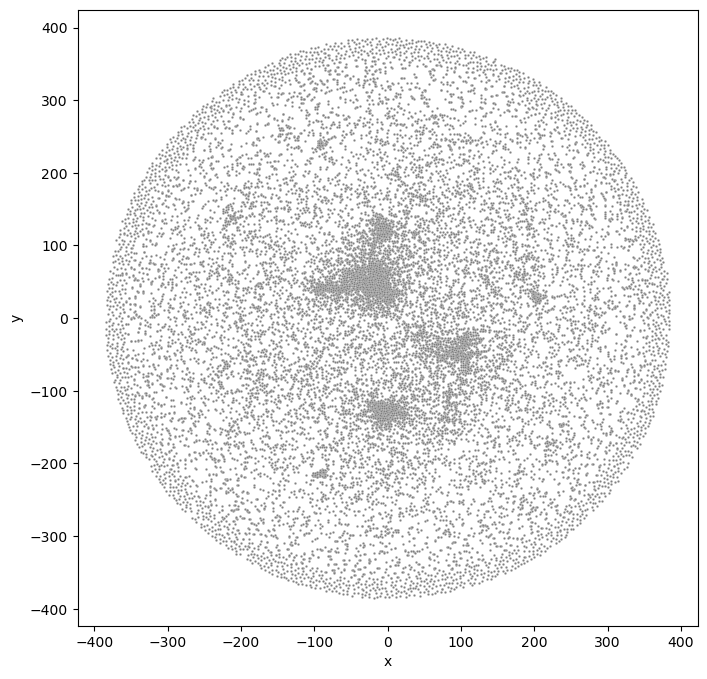

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=cd_out_hit_df, x='x', y='y', color='grey', s=3)
plt.show()

### All Hits

#### Create DataFrame for all RegEx Hits

In [17]:
full_hit_df = pd.DataFrame(columns=['id', 'stretch_x', 'seq_x', 'header'])
ix = 0

with open(full_fasta_file, 'r') as file:

    lines = [line.strip() for line in file.readlines()]
    headers = lines[::2]
    seqs = lines[1::2]
    
    for hx, header_str in enumerate(headers):
        
        print(f'Progress: {hx+1}/{len(headers)}', end='\r')

        header = header_str.split('_')
        id, strx, sx = '_'.join(header[:-7])[1:], header[-3], header[-1]
        full_hit_df.loc[ix] = [id, strx, sx, header_str[1:]]
        ix += 1

In [18]:
# Assign each hit its representative hit
full_hit_df['rep_id'] = full_hit_df['header'].apply(lambda x: rep_dict[x])

In [19]:
print(len(full_hit_df))
full_hit_df.head()

31791


,id,stretch_x,seq_x,header,rep_id
0,WP_018518335.1,0,0,WP_018518335.1_3R_0MM_seq_stretch_0_seq_0,WP_018518335.1_3R_0MM_seq_stretch_0_seq_0
1,WP_018518335.1,0,1,WP_018518335.1_3R_0MM_seq_stretch_0_seq_1,WP_018518335.1_3R_0MM_seq_stretch_0_seq_1
2,QZI86829.1,0,0,QZI86829.1_3R_0MM_seq_stretch_0_seq_0,QZI86829.1_3R_0MM_seq_stretch_0_seq_0
3,MBQ9252633.1,0,0,MBQ9252633.1_3R_0MM_seq_stretch_0_seq_0,MBQ9252633.1_3R_0MM_seq_stretch_0_seq_0
4,MBQ9252633.1,0,1,MBQ9252633.1_3R_0MM_seq_stretch_0_seq_1,MBQ9252633.1_3R_0MM_seq_stretch_0_seq_1


#### Merge Reprenstative and Full Hit DataFrame

In [20]:
merged_df = full_hit_df.merge(cd_out_hit_df[['rep_id', 'c']], on='rep_id', how='right')

print(len(merged_df))
merged_df.head(5)

31791


,id,stretch_x,seq_x,header,rep_id,c
0,WP_018518335.1,0,0,WP_018518335.1_3R_0MM_seq_stretch_0_seq_0,WP_018518335.1_3R_0MM_seq_stretch_0_seq_0,-1.0
1,WP_018518335.1,0,1,WP_018518335.1_3R_0MM_seq_stretch_0_seq_1,WP_018518335.1_3R_0MM_seq_stretch_0_seq_1,-1.0
2,QZI86829.1,0,0,QZI86829.1_3R_0MM_seq_stretch_0_seq_0,QZI86829.1_3R_0MM_seq_stretch_0_seq_0,-1.0
3,MBQ9252633.1,0,0,MBQ9252633.1_3R_0MM_seq_stretch_0_seq_0,MBQ9252633.1_3R_0MM_seq_stretch_0_seq_0,-1.0
4,MBO5569970.1,0,1,MBO5569970.1_3R_0MM_seq_stretch_0_seq_1,MBQ9252633.1_3R_0MM_seq_stretch_0_seq_0,-1.0


### TMP Sequences

#### Derive Cluster Profile for Original Sequences

In [21]:
cluster_cols = [f'C{ix}' for ix in range(len(clans_numbers))] + ['C-1']
tmp_df[cluster_cols] = 0

In [22]:
for ix in range(len(tmp_df)): 
    print(f'Progress: {ix+1}/{len(tmp_df)}', end='\r')

    current_seq = tmp_df.iloc[ix]
    current_id = current_seq['id']

    tmp_merged_df = merged_df[merged_df['id'] == current_id]

    for cluster in tmp_merged_df['c']:
        tmp_df.loc[ix, f'C{int(float(cluster))}'] += 1

In [23]:
np.all(tmp_df[cluster_cols].sum(axis=1) == tmp_df[f'{R}R_{M}MM_n'])

True

In [66]:
heights = [0 for _ in range(len(clans_numbers) + 1)]
heights_w_unassigned = [0 for _ in range(len(clans_numbers) + 1)]

for i in range(len(tmp_df)):
    current_seq = tmp_df.iloc[i]

    c = 0
    c_unassigned = 0

    for cx in [f'C{ix}' for ix in range(len(clans_numbers))]:
        if current_seq[cx] > 0:
            c += 1
            c_unassigned += 1
    
    if current_seq['C-1'] > 0:
        c_unassigned += 1

    heights[c] += 1
    heights_w_unassigned[c_unassigned] += 1

In [67]:
heights

[2189, 788, 135, 24, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]

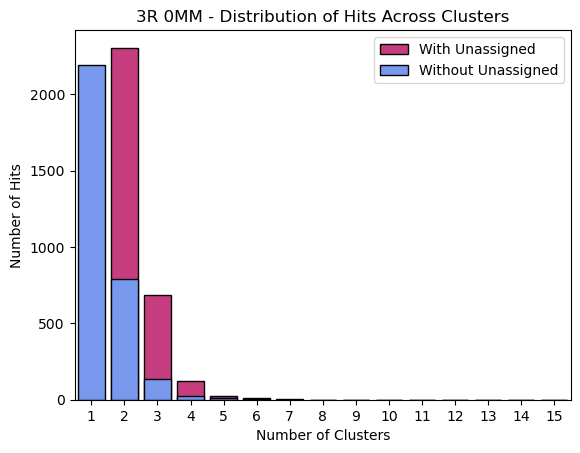

In [25]:
sns.barplot(x=list(range(1, len(clans_numbers) + 2)), y=heights_w_unassigned, edgecolor='black', color='#DC267F', label='With Unassigned')   
sns.barplot(x=list(range(1, len(clans_numbers) + 2)), y=heights, edgecolor='black', color='#648FFF', label='Without Unassigned')   


plt.title(f'{R}R {M}MM - Distribution of Hits Across Clusters')
    
plt.xlabel('Number of Clusters')
plt.ylabel('Number of Hits')

plt.legend()

if os.getcwd() == lothar:
    plt.savefig(f'/home/enno/uni/SS24/thesis/1_RegEx/1_TMP/plots/{R}R_{M}MM_{E}.png')
else:
    plt.savefig(f'/ebio/abt1_share/prediction_hendecads/1_repo/1_RegEx/1_TMP/plots/{R}R_{M}MM_{E}.png')
plt.show()

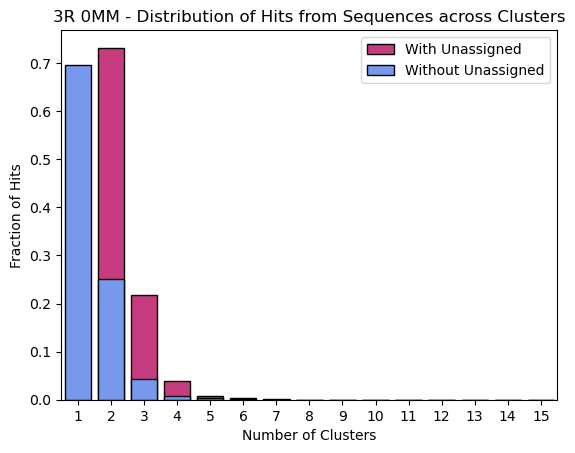

In [85]:
from sklearn.preprocessing import MinMaxScaler

normalized_heights = np.array(heights) / sum(heights)
normalized_heights_w_unassigned = np.array(heights_w_unassigned) / sum(heights_w_unassigned)

sns.barplot(x=list(range(1, len(clans_numbers) + 2)), y=normalized_heights_w_unassigned, edgecolor='black', color='#DC267F', label='With Unassigned')   
sns.barplot(x=list(range(1, len(clans_numbers) + 2)), y=normalized_heights, edgecolor='black', color='#648FFF', label='Without Unassigned')   


plt.title(f'{R}R {M}MM - Distribution of Hits from Sequences across Clusters')
    
plt.xlabel('Number of Clusters')
plt.ylabel('Fraction of Hits')

plt.legend()


if os.getcwd() == lothar:
    plt.savefig(f'/home/enno/uni/SS24/thesis/1_RegEx/1_TMP/plots/{R}R_{M}MM_{E}_norm.png')
else:
    plt.savefig(f'/ebio/abt1_share/prediction_hendecads/1_repo/1_RegEx/1_TMP/plots/{R}R_{M}MM_{E}_norm.png')
plt.show()

In [88]:
cd_out_hit_df

,id,stretch_x,seq_x,rep_id,c,x,y
0,WP_018518335.1,0,0,WP_018518335.1_3R_0MM_seq_stretch_0_seq_0,-1,-254.055590,208.668150
1,WP_018518335.1,0,1,WP_018518335.1_3R_0MM_seq_stretch_0_seq_1,-1,-84.364105,-375.624970
2,QZI86829.1,0,0,QZI86829.1_3R_0MM_seq_stretch_0_seq_0,-1,274.806820,253.753720
3,MBQ9252633.1,0,0,MBQ9252633.1_3R_0MM_seq_stretch_0_seq_0,-1,-225.752720,-33.800556
4,MBQ9252633.1,0,1,MBQ9252633.1_3R_0MM_seq_stretch_0_seq_1,-1,-231.982320,-6.556469
...,...,...,...,...,...,...,...
18039,DAU86930.1,0,1,DAU86930.1_3R_0MM_seq_stretch_0_seq_1,12,6.234720,-124.432950
18040,DAU86930.1,0,2,DAU86930.1_3R_0MM_seq_stretch_0_seq_2,-1,11.779735,-123.425740
18041,DAU86930.1,0,3,DAU86930.1_3R_0MM_seq_stretch_0_seq_3,12,-4.284698,-127.740364
18042,DAU86930.1,0,7,DAU86930.1_3R_0MM_seq_stretch_0_seq_7,-1,224.468120,13.906368


#### Change of Detected Hit Counts

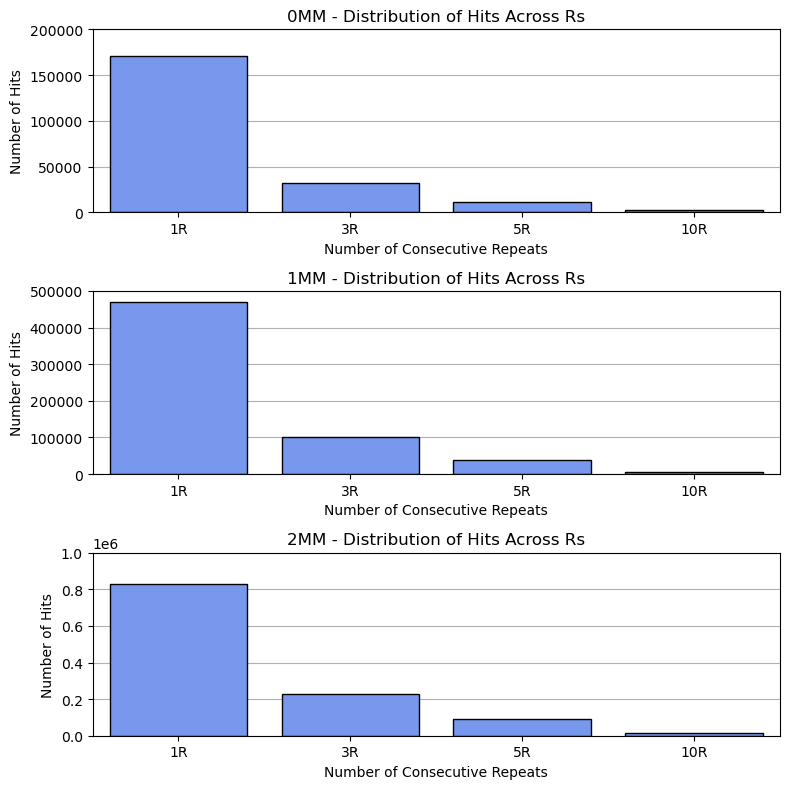

In [47]:
Rs = [1, 3, 5, 10]
Ms = [0, 1, 2]
ylims = [0.2*1e6, 0.5*1e6, 1e6]
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

for mx, m in enumerate(Ms):
    
    heights = []
    for r in Rs:

        heights.append(full_tmp_df[f'{r}R_{m}MM_n'].sum())

    sns.barplot(x=[f'{r}R' for r in Rs], y=heights, edgecolor='black', color='#648FFF', ax=axs[mx])
    axs[mx].set_title(f'{m}MM - Distribution of Hits Across Rs')
    axs[mx].set_xlabel('Number of Consecutive Repeats')
    axs[mx].set_ylabel('Number of Hits')
    axs[mx].set_ylim(0, ylims[mx])
    axs[mx].grid(axis='y')
    axs[mx].set_axisbelow(True)



plt.tight_layout()  
plt.show()

### CLANS

In [28]:
if os.getcwd() == lothar:
    tmp_only_clans_file = '/home/enno/uni/SS24/thesis/1_RegEx/1_TMP/TMP_1E-40.clans'
else:
    tmp_only_clans_file = '/ebio/abt1_share/prediction_hendecads/1_repo/1_RegEx/1_TMP/TMP_1E-40.clans'

#### Get TMP only Coordinates

In [29]:
# Read the fasta IDs from the TMP 14E-40.clans file
with open(tmp_only_clans_file, 'r') as file:
    content = file.read()
    fasta_ids = re.findall(r'>\S+', content)

fasta_ids = [x[1:] for x in fasta_ids]
len(fasta_ids)

4936

In [30]:
with open(tmp_only_clans_file, 'r') as file:
    content = file.readlines()
    content = [x.strip() for x in content]

first_pos = 1
for line in content:
    if line == '<pos>':
        break
    else:
        first_pos += 1

last_pos = first_pos + len(full_tmp_df) + 1

pos = [x.split() for x in content[first_pos:last_pos]]
pos = [(float(x[1]), float(x[2])) for x in pos]
len(pos)

4936

In [31]:
pos_dict = {}

for ix, seq_id in enumerate(fasta_ids):
    pos_dict[seq_id] = pos[ix]

In [32]:
full_tmp_df['tmp_only_x'] = [pos_dict[x][0] for x in full_tmp_df['id']]
full_tmp_df['tmp_only_y'] = [pos_dict[x][1] for x in full_tmp_df['id']]

#### Maps

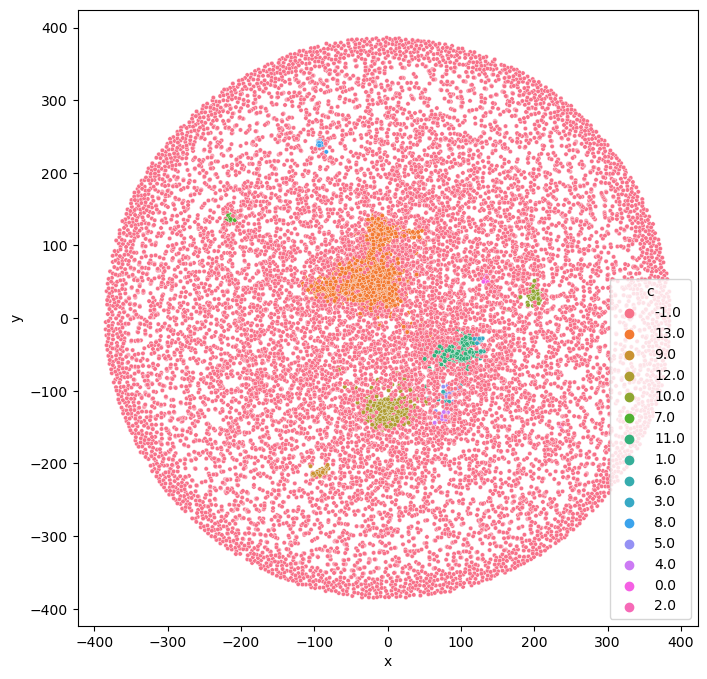

In [33]:
fig, axes = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=cd_out_hit_df, x='x', y='y', hue='c', s=10)
# Pick sequence and check its assignments

plt.show()

#### Track Sequences and Hits across CLANS Maps

In [45]:
# tmp_df[tmp_df[cluster_cols[:-1]].apply(lambda row: (row != 0).sum(), axis=1) == 0][['id'] + cluster_cols]

In [56]:
tmp_df[(tmp_df['C1'] > 0) & (tmp_df['C3'] > 0)][['id'] + cluster_cols]


,id,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C-1
192,YP_009818849.1,0,3,0,2,0,0,0,0,1,0,0,14,0,1,5
459,WP_096919592.1,0,1,0,1,0,0,0,0,0,0,0,9,0,8,38
591,WP_157738521.1,0,1,0,1,0,0,0,0,0,0,0,7,0,14,9
756,WP_128705534.1,0,1,0,2,0,0,0,0,0,0,0,9,0,25,12
1745,DAO63024.1,0,1,0,1,0,0,0,0,0,0,0,5,0,0,16
2078,DAJ05879.1,0,1,0,1,0,0,0,0,1,0,0,8,0,20,5
2995,MBQ7292581.1,0,4,0,4,0,0,0,0,1,0,0,27,0,28,3
3110,MBD5145638.1,0,1,0,2,0,0,0,0,0,0,0,6,0,0,11


In [59]:
test_seq = 'MBQ7292581.1'
tmp_df[tmp_df['id'] == test_seq]['3R_0MM_n']

2995    67
Name: 3R_0MM_n, dtype: int64

In [60]:
full_hit_df[full_hit_df['id'] == test_seq]

,id,stretch_x,seq_x,header,rep_id
29942,MBQ7292581.1,0,0,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_0,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_0
29943,MBQ7292581.1,0,1,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_1,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_1
29944,MBQ7292581.1,0,2,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_2,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_2
29945,MBQ7292581.1,0,3,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_3,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_2
29946,MBQ7292581.1,0,4,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_4,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_2
...,...,...,...,...,...
30004,MBQ7292581.1,0,62,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_62,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_59
30005,MBQ7292581.1,0,63,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_63,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_63
30006,MBQ7292581.1,0,64,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_64,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_63
30007,MBQ7292581.1,0,65,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_65,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_65


In [65]:
cd_out_hit_df[cd_out_hit_df['id'] == test_seq]

,id,stretch_x,seq_x,rep_id,c,x,y
17027,MBQ7292581.1,0,0,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_0,-1.0,-6.553477,-11.061419
17028,MBQ7292581.1,0,1,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_1,-1.0,-17.163311,-6.448929
17029,MBQ7292581.1,0,2,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_2,13.0,-22.433695,19.347383
17030,MBQ7292581.1,0,5,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_5,13.0,-23.407630,13.066998
17031,MBQ7292581.1,0,9,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_9,13.0,-30.366316,31.962807
17032,MBQ7292581.1,0,12,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_12,13.0,-34.278160,44.519802
17033,MBQ7292581.1,0,14,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_14,13.0,-70.986940,40.963936
17034,MBQ7292581.1,0,17,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_17,13.0,-84.384735,38.295383
17035,MBQ7292581.1,0,20,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_20,13.0,-45.812756,57.794260
17036,MBQ7292581.1,0,24,MBQ7292581.1_3R_0MM_seq_stretch_0_seq_24,13.0,-23.937895,90.782610


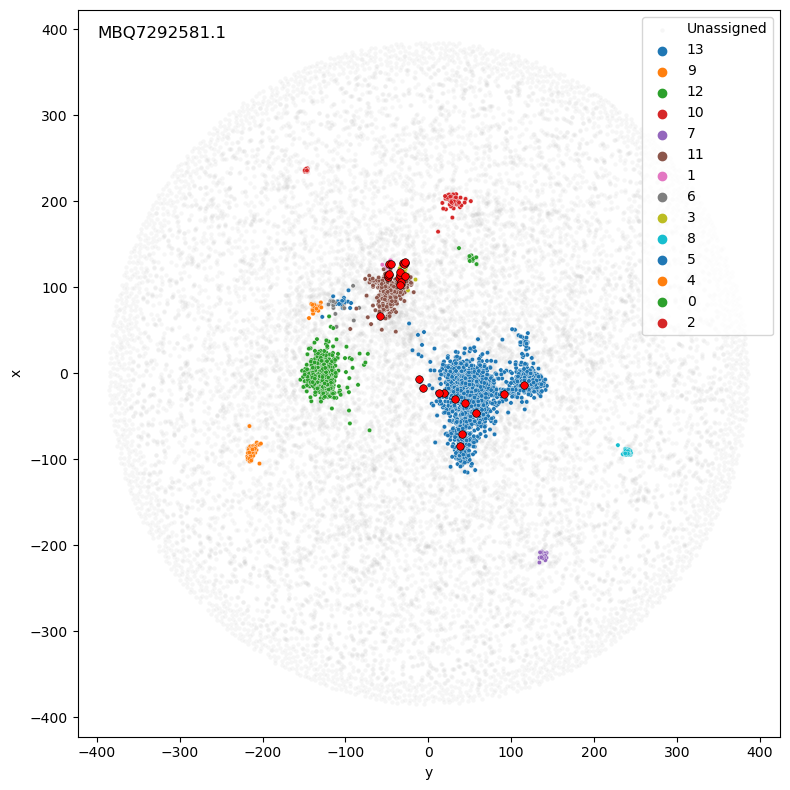

In [84]:
fig, ax = plt.subplots(figsize=(8, 8))
cd_out_hit_df['c'] = cd_out_hit_df['c'].astype(float).astype(int).astype(str)
sns.scatterplot(data=cd_out_hit_df[cd_out_hit_df['c'] == '-1'], x='y', y='x', s=10, c='darkgrey', ax=ax, label='Unassigned', alpha=0.1)
sns.scatterplot(data=cd_out_hit_df[cd_out_hit_df['c'] != '-1'], x='y', y='x', s=10, hue='c', ax=ax, palette='tab10', legend='full')
sns.scatterplot(data=cd_out_hit_df[(cd_out_hit_df['id'] == test_seq)], x='y', y='x', s=30, c='red', ax=ax, edgecolor='black')

plt.text(-400, 390, test_seq, fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()

In [43]:
full_tmp_df[full_tmp_df['id'] == test_seq]

,id,seq,stretch_ix,stretch_seq,c,npf_x,npf_y,1R_0MM_seq,1R_0MM_ix,1R_0MM_n,...,3R_2MM_ix,3R_2MM_n,5R_2MM_seq,5R_2MM_ix,5R_2MM_n,10R_2MM_seq,10R_2MM_ix,10R_2MM_n,tmp_only_x,tmp_only_y
4930,WP_122014491.1,masqkelralitlagkvdpslqtalmtasaqtskasrtfsklgsfa...,"[[179, 180, 181, 182, 183, 184, 185, 186, 187,...",['adrnalafklfgrgaaelfpilnagtdeiqklaaeadklglvms...,0.0,-149.0837,-79.52078,"[['aaelfpilnag', 'iqklaaeadkl', 'adklglvmsge',...","[[[14, 25], [28, 39], [35, 46], [50, 61], [57,...",72,...,"[[[6, 39], [28, 61], [35, 68], [42, 75], [46, ...",111,[['adklglvmsgeqvealdnlgdtidklklsvmglgnrilasllp...,"[[[35, 90], [46, 101], [50, 105], [57, 112], [...",68,[['llnvasqfaqilmpifdtigstmgpmlvniiqqalpivmqiiq...,"[[[115, 225], [126, 236], [133, 243], [137, 24...",10,-16.992838,-109.43631


#### Majority Vote

In [102]:
# merge cluster cols into full tmp df for id
dff = full_tmp_df[full_tmp_df['3R_0MM_n'] > 0].merge(tmp_df[['id'] + cluster_cols], on='id', how='left')

In [104]:
# make a new column for dff which contains the cluster col with the highest value
dff['max_cluster'] = dff[cluster_cols].idxmax(axis=1)


<Axes: xlabel='tmp_only_x', ylabel='tmp_only_y'>

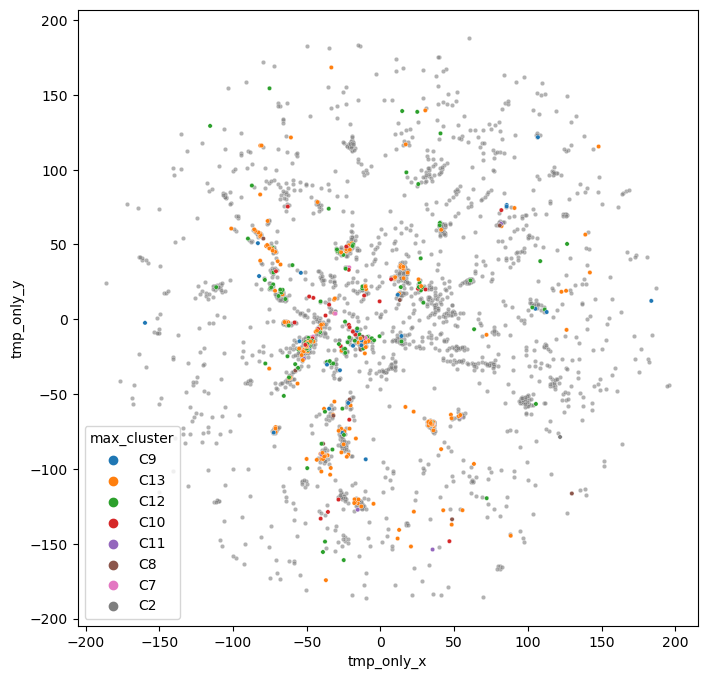

In [112]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=dff[dff['max_cluster'] == 'C-1'], x='tmp_only_x', y='tmp_only_y', s=10, color='grey', ax=ax, alpha=0.6)
sns.scatterplot(data=dff[dff['max_cluster'] != 'C-1'], x='tmp_only_x', y='tmp_only_y', s=10, hue='max_cluster', ax=ax, palette='tab10', legend='full')


In [113]:
dff.max_cluster.value_counts()

max_cluster
C-1    2700
C13     231
C12     121
C10      36
C9       31
C8       13
C11      11
C7        4
C2        1
Name: count, dtype: int64